# Exercise - NumPy to CuPy - SVD Reconstruction - SOLUTION

Let's try another NumPy to CuPy porting exercise, this time with the SVD reconstruction code from before.

We had to make the following changes:

- Change `import numpy as xp` to `import cupy as xp`.
- NumPy arrays are converted to CuPy arrays using `xp.asarray()`.  You'll see errors like `only supports cupy.ndarray` when you have this problem.
- CuPy arrays are converted back to NumPy arrays (for Matplotlib) using `xp.asnumpy()`.

First, we need to import the compute vision and plotting stack we're using:

In [ ]:
import matplotlib.pyplot as plt
import cv2
import cupy as xp

Next let's download an image of Bryce's dog:

In [ ]:
import urllib.request
urllib.request.urlretrieve(
  "https://drive.usercontent.google.com/download?id=1ClKrHt4-SIHaeBJdF0K3MG64jyVnt62L&export=download",
  "loonie.jpg")

('loonie.jpg', <http.client.HTTPMessage at 0x7c53c698ef10>)

Next we can read the image in grayscale mode:

In [ ]:
image = cv2.imread('loonie.jpg', cv2.IMREAD_GRAYSCALE)

image = xp.asarray(image) # Copy the image to the GPU.

print(f"nbytes: {image.nbytes}")
print(f"shape: {image.shape}")
print(image)

nbytes: 1920000
shape: (1600, 1200)
[[127 128 135 ...  74  70  70]
 [128 132 135 ...  78  69  72]
 [119 127 131 ...  84  75  71]
 ...
 [140 133 127 ... 126 139 123]
 [144 136 129 ... 130 124 115]
 [155 145 133 ... 124 114 117]]


Here we can see the image is 1600x1200 pixels, and each pixel is an unsigned 8-bit value (0-255).  Let's plot it with matplotlib to verify it looks correct:

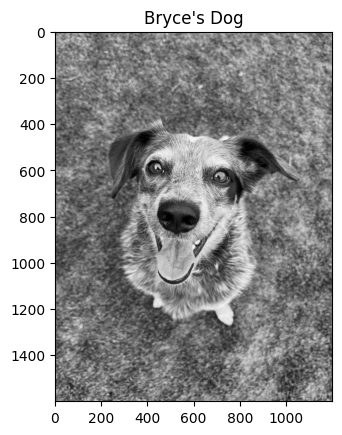

In [ ]:
# We need to bring GPU image back to CPU with
# `cp.asnumpy()` to plot it with matplotlib.

plt.imshow(xp.asnumpy(image), cmap="gray")
plt.title("Bryce's Dog")
plt.show()

Yes, we can confirm that is a dog (and a very cute one at that).  Now let's start doing some linear algebra!

NumPy provides an [implementation of SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).  By selecting `full_matrices=False`, we get the singular value matrix, `S`, as a 1D vector rather than a 2D diagonal matrix.

In [ ]:
U, S, Vt = xp.linalg.svd(image, full_matrices=False)
U.shape, S.shape, Vt.shape

((1600, 1200), (1200,), (1200, 1200))

Since the image is not square and we've not selected `full_matrices`, NumPy returns `U` as a non-square matrix, `S` as the 1D vector which is the smaller of the two dimensions, and the `Vt` matrix is a square matrix.

The signular values are returned in descending order, which we can see if we look at the first 10 elements of `S`:

In [ ]:
S[:10]

array([168083.9407829 ,  23238.38484043,  19528.95172263,  15942.48480149,
        11745.41886782,  10402.5500467 ,   9557.42759704,   9301.19899873,
         8220.25409214,   8070.18502333])

In fact, if we look at the size of the singular values, we see that the first few contribute a lot to the matrix, and then fall off very rapidly:

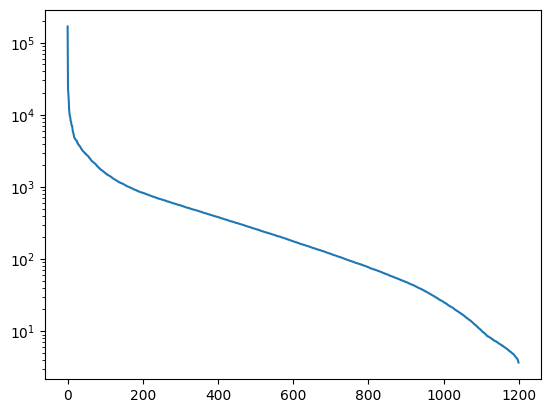

In [ ]:
# We need to copy the singular value matrix back to the CPU here.
plt.semilogy(xp.asnumpy(S))

That suggests we can get a pretty good approximation of the original image with a relatively small number of terms.  We can reconstruct the image matrix by slicing the `U`, `S`, and `Vt` matrices and remultiplying them.  We will need to convert `S` back into a 2D matrix for the multiplication as well.  Note that we are using the `@` operator to perform matrix multiplication, because `*` does element-wise multiplication.

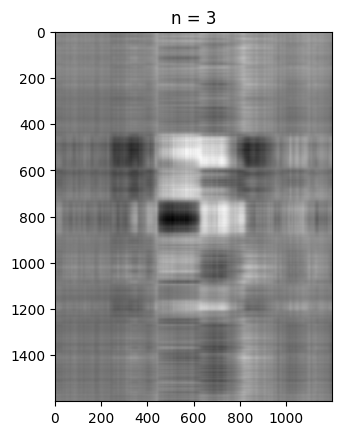

In [ ]:
# First 3 terms.
nterms = 3
reconstructed = U[:, :nterms] @ xp.diag(S[:nterms]) @ Vt[:nterms, :]

# We need to copy the reconstructed matrix back to the CPU.
plt.imshow(xp.asnumpy(reconstructed), cmap="gray")
plt.title("n = 3")
plt.show()

That's still pretty fuzzy, so let's check out the image with more terms included:

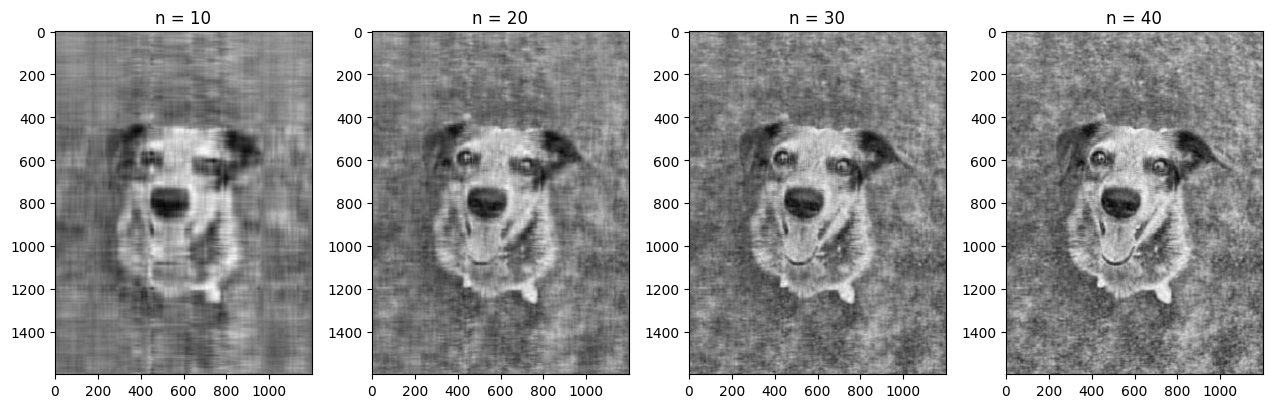

In [ ]:
plt.figure(figsize=(16, 4))

start, end, step = 10, 50, 10
for i in range(start, end, step):
  plt.subplot(1, (end - start) // step + 1, (i - start) // step + 1)
  reconstructed = U[:, :i] @ xp.diag(S[:i]) @ Vt[:i, :]
  # Copy the reconstructed matrix back to the CPU.
  plt.imshow(xp.asnumpy(reconstructed), cmap="gray")
  plt.title(f"n = {i}")

plt.tight_layout()
plt.show()

Did you have a chance to think about the compute and I/O pattern in the previous cell and how it could be improved? The answer is asynchrony - don't worry, we'll cover that in greater detail in future exercises.

Now we'll print the compression ratio for the values of `n` used above.  This is the number of bytes of the reduced arrays added together and divided by the size of the original grayscale image array.  It seems we can get significant storage savings with this technique.

In [ ]:
for i in range(start, end, step):
  compress_ratio = (U[:, :i].nbytes + S[:i].nbytes + Vt[:i, :].nbytes) / image.nbytes
  print(f"n = {i}: compression = {compress_ratio:.1%}")

n = 10: compression = 11.7%
n = 20: compression = 23.3%
n = 30: compression = 35.0%
n = 40: compression = 46.7%


Next, we compute and display the difference in the reconstruction for `n = 10` and the original image using `cmap="coolwarm"` to display the difference.

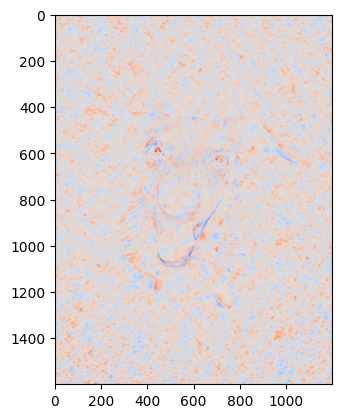

In [ ]:
delta = image - (U[:,:10] @ xp.diag(S[:10]) @ Vt[:10,:])
# Copy the delta matrix back to the CPU.
plt.imshow(xp.asnumpy(delta), cmap="coolwarm")

Now that you have gotten SVD to work on CuPy, let's benchmark the speed.  To make things clearer, let's reimport NumPy and CuPy with their usual abbreviations:

In [ ]:
import numpy as np
import cupy as cp
import cupyx as cpx # For `cupyx.profiler.benchmark`.

We have to be very careful when benchmarking GPU code. As GPU programming is inherently asynchronous, so it can be tricky to make sure we're measuring the right thing.

Imagine you're measuring how long it takes to ship a package to someone, but you only time how long it takes for you to drop it off at the post office, not how long it takes for them to receive it and send you a thank you.

Common Pythonic benchmarking tools like `%timeit` are not GPU aware, so it's easy to measure incorrectly with them.  We can only use them when we know the code we're benchmarking will perform the proper synchronization.  It's better to use something like [`cupyx.profiler.benchmark`](https://docs.cupy.dev/en/stable/reference/generated/cupyx.profiler.benchmark.html#cupyx.profiler.benchmark).

First, we need a NumPy (CPU) and CuPy (GPU) copy of our image:

In [ ]:
cpu_image = cv2.imread("loonie.jpg", cv2.IMREAD_GRAYSCALE)
gpu_image = cp.asarray(cpu_image)

Next let's benchmark both CPU and GPU execution:

In [ ]:
repeat = 10
warmup = 1
D_np = cpx.profiler.benchmark(n_repeat=repeat, n_warmup=warmup, func=lambda:
  np.linalg.svd(cpu_image, full_matrices=False)
).cpu_times
D_cp = cpx.profiler.benchmark(n_repeat=repeat, n_warmup=warmup, func=lambda:
  cp.linalg.svd(gpu_image, full_matrices=False)
).cpu_times

print(f"SVD (Host)   = {D_np.mean():.3g} s ± {(D_np.std() / D_np.mean()):.2%} (mean ± relative stdev of {D_np.size} runs)")
print(f"SVD (Device) = {D_cp.mean():.3g} s ± {(D_cp.std() / D_cp.mean()):.2%} (mean ± relative stdev of {D_cp.size} runs)")

SVD (Host)   = 1.73 s ± 32.03% (mean ± relative stdev of 10 runs)
SVD (Device) = 0.686 s ± 0.22% (mean ± relative stdev of 10 runs)


Depending on your hardware, the CPU and GPU might be close to the same speed, or the GPU might even be slower!  This is because the image is not big enough to fully utilize the GPU.  We can simulate a larger image by tiling the image using `np.tile`.  This duplicates the image both along axis 0 and axis 1:

In [ ]:
# With 3x3 tiling we should see the GPU significantly outperform the CPU.
cpu_image_tile = np.tile(cpu_image, (3, 3))
gpu_image_tile = cp.asarray(cpu_image_tile)

Now we can benchmark again (this will take longer because the matrices are much bigger):

In [ ]:
repeat = 5
warmup = 1
D_np = cpx.profiler.benchmark(n_repeat=repeat, n_warmup=warmup, func=lambda:
  np.linalg.svd(cpu_image_tile, full_matrices=False)
).cpu_times
D_cp = cpx.profiler.benchmark(n_repeat=repeat, n_warmup=warmup, func=lambda:
  cp.linalg.svd(gpu_image_tile, full_matrices=False)
).cpu_times

print(f"SVD (Host)   = {D_np.mean():.3g} s ± {(D_np.std() / D_np.mean()):.2%} (mean ± relative stdev of {D_np.size} runs)")
print(f"SVD (Device) = {D_cp.mean():.3g} s ± {(D_cp.std() / D_cp.mean()):.2%} (mean ± relative stdev of {D_cp.size} runs)")

SVD (Host)   = 44.3 s ± 2.81% (mean ± relative stdev of 5 runs)
SVD (Device) = 6.98 s ± 1.11% (mean ± relative stdev of 5 runs)


This problem starts to see a benefit for GPUs for images of this size:

In [ ]:
gpu_image_tile.shape

(4800, 3600)